# Daskgateway example
The motivation of this example is to demonstrate using Dask Gateway to allocate and use a Dask cluster.

## Software used
- [xarray](http://xarray.pydata.org/en/stable/index.html)
- [zarr](https://zarr.readthedocs.io/en/stable/index.html)
- [s3fs](https://github.com/dask/s3fs)
- [dask](https://docs.dask.org/en/latest/)
- [daskgateway](https://gateway.dask.org/index.html)

## Environment
Below is the command to create the conda environment to use. This uses the [mamba](https://github.com/mamba-org/mamba), a reimplementation of conda in c++. You can replace `mamba` with `conda` and achieve the same result.

```bash
mamba env create -n daskgateway esgf-compute/daskgateway
mamba activate daskgateway
mamba install -c conda-forge --freeze-installed matplotlib ipykernel ipywidgets
```

In [1]:
import xarray as xr

In [2]:
identifier = "so_Omon_HadGEM3-GC31-MM_historical_r1i1p1f3_gn"

data_path = "/CMIP6/CMIP/MOHC/HadGEM3-GC31-MM/historical/r1i1p1f3/Omon/so/gn/v20191216"

## Open the data

Lets open the multi file dataset using xarray and chunk along the time and lev axes. The dataset is composed of 18 files with a size of ~216 GB.

In [3]:
ds = xr.open_mfdataset(f"{data_path}/*.nc", chunks={"time": 100, "lev": 1})
ds

<xarray.Dataset>
Dimensions:             (bnds: 2, i: 1440, j: 1205, lev: 75, time: 1980, vertices: 4)
Coordinates:
  * time                (time) object 1850-01-16 00:00:00 ... 2014-12-16 00:0...
  * lev                 (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * j                   (j) int32 0 1 2 3 4 5 ... 1199 1200 1201 1202 1203 1204
  * i                   (i) int32 0 1 2 3 4 5 ... 1434 1435 1436 1437 1438 1439
    latitude            (j, i) float32 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
    longitude           (j, i) float32 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds           (time, bnds) object dask.array<chunksize=(100, 2), meta=np.ndarray>
    lev_bnds            (time, lev, bnds) float64 dask.array<chunksize=(120, 1, 2), meta=np.ndarray>
    vertices_latitude   (time, j, i, vertices) float32 dask.array<chunksize=(120, 1205, 1440, 4), meta=np.ndarray>
    vertices_longitude  (time, j, i, vertices) float32 dask.array<chunksize=(120, 1205, 1440, 4), meta=np.ndarray>
    so                  (time, lev, j, i) float32 dask.array<chunksize=(100, 1, 1205, 1440), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    creation_date:          2019-12-11T16:05:48Z
    ...                     ...
    tracking_id:            hdl:21.14100/39bfbb7f-7f70-4015-8f7f-c269e4b70806
    variable_id:            so
    variable_name:          so
    variant_label:          r1i1p1f3
    license:                CMIP6 model data produced by the Met Office Hadle...
    cmor_version:           3.4.0

## Use Dask Gateway to allocate and connect to the cluster

We could create a local Dask Cluster with distributed's LocalCluster.

```python
from distributed import LocalCluster, Client
cluster = LocalCluster(n_workers=7, threads_per_worker=2)
client = Client(cluster)
```

In this case we're constrained to local resources. By using Dask Gateway we can use up to 40 CPU Cores or 150 GB of memory versus the 16 and 32 we have locally.

In [4]:
import os
import dask_gateway

DASK_GATEWAY_HOST = os.environ["DASK_GATEWAY_HOST"]

In [5]:
gateway = dask_gateway.Gateway(f"http://{DASK_GATEWAY_HOST}", auth="jupyterhub")

gateway.list_clusters()

[]

#### Configure the worker specs
We can configure the workers for our specific use case. We've constrained the resources to either 40 workers, 40 CPU cores or 150 GB of memory, whichever limit we hit first.

In [6]:
options = gateway.cluster_options()
options

#### Create the cluster and scale the workers
With the setting below you'll see a warning noting that the cluster could only scale to 18 workers due to hitting the memory limit.

It is advised that you explicitly shutdown your clusters when done, remember you're sharing these resources with other users.
```python
cluster.shutdown()
```

You can remove existing clusters with the following.
```python
for x in gateway.list_clusters():
    gateway.connect(x.name).shutdown()
```

In [7]:
for x in gateway.list_clusters():
    gateway.connect(x.name).shutdown()

In [8]:
options.worker_cores = 2
options.worker_threads = 8
options.worker_memory = 8

cluster = gateway.new_cluster(options)
cluster

In [9]:
cluster.adapt(0, 40)

/home/jovyan/conda-envs/daskgateway/lib/python3.8/site-packages/dask_gateway/client.py:673: GatewayWarning: Scale request of 40 workers would exceed resource limit of 24 workers. Scaling to 24 instead.
  warnings.warn(GatewayWarning(msg["msg"]))


#### Connect to your cluster dashboard
The dashboard link is using the internal ingress controller. If you replace the host with `nimbus1.llnl.gov` you will be able to view the dashboard externally.

In [10]:
cluster.dashboard_link.replace('http://traefik-dask-gateway.production.svc', 'https://nimbus1.llnl.gov')

'https://nimbus1.llnl.gov/clusters/production.7f9a8b8547b84575a16635af6fe4df52/status'

#### Connect a client and perform some work.
Here we'll calculate the monthly means for 2 levels then concatenate back to a single dataset, write to a file and visualize a single level.

In [11]:
client = cluster.get_client()

In [12]:
%%time

climos = []

for x in range(2):
    result = ds.isel(lev=x).groupby("time.month").mean(dim="time").compute()
    
    climos.append(result)

CPU times: user 6.12 s, sys: 4.26 s, total: 10.4 s
Wall time: 3min 14s


In [13]:
result = xr.concat(climos, "lev")
# result.to_netcdf("test.nc")

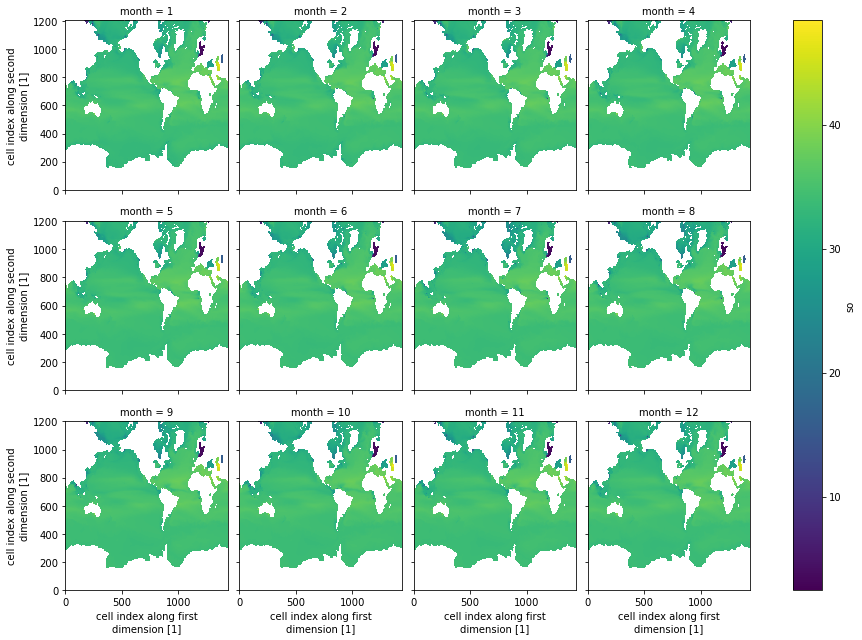

In [14]:
result.isel(lev=0).so.plot(x="i", y="j", col="month", col_wrap=4)

In [15]:
cluster.close()